In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from scipy.linalg import toeplitz

import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use('seaborn-poster')

### 1
**(a)** By page 52 in notes, the spectual density function of an $\text{ARMA}(p, q)$ process is  given by
\begin{equation}
S_X(f) = \sigma_{\epsilon}^2\frac{G_{\theta}(f)}{G_{\phi}(f)}.
\end{equation}
where $$G_{\theta}(f)=|1-\theta_{1,q}e^{-2i\pi f}-...-\theta_{q, q}e^{-2i\pi fq}|^2, $$ $$G_{\phi}(f)=|1-\phi_{1, q}e^{-2i\pi f}-...-\phi_{q, q}e^{-2i\pi fq}|^2.$$

In [2]:
def S_ARMA(f, sigma2, phis=[], thetas=[]):
    '''
    Computes the theoretical sdf for an ARMA(p, q) process.

    param f: numpy array of frequencies at which sdf should be evaluated
    param sigma2: scalar; the variance of the white noise process
    param phis: array containing the phi parameters
    param thetas: array containing the theta parameters
    
    return: numpy array of sdf evaluated at f
    '''
    p, q = len(phis), len(thetas)
    xis_t = np.exp(-1j*2*np.pi*np.outer(f, np.arange(1, q+1)))
    xis_p = np.exp(-1j*2*np.pi*np.outer(f, np.arange(1, p+1)))
    G_t = 1 - (thetas * xis_t).sum(1)  # G_theta
    G_p = 1 - (phis * xis_p).sum(1)    # G_phi
    return (sigma2 * np.abs(G_t)**2 / np.abs(G_p)**2)

**(b)** The following code implements the burn in method to generate an $\text{ARMA}(2,2)$ process of length $N$: 
\begin{enumerate}
    \item Set $X_1=X_2=0$ 
    \item For $i=3$ to $100+N$, set $X_i \gets \phi_{1,2} X_{i-1}+\phi_{2,2}X_{i-2}+\epsilon_i-\theta_{1, 2}\epsilon_{i-1}-\theta_{2,2}\epsilon_{i-2}$ 
    \item Return $X_{101},...,X_{101+N}$. 
\end{enmerate}

In [3]:
def ARMA22_sim(phis, thetas, sigma2, N):
    """
    Simulates a Gaussian ARMA(2,2) process. 

    param phis: numpy array containing the phi parameters
    param thetas: numpy array containing the theta parameters
    param sigma2: scalar; variance of the white noise process
    N: scalar; length of the simulated process

    return: numpy array of size N; realiasation of an ARMA(2,2) process
    """
    eps = np.random.normal(size=100+N, scale=np.sqrt(sigma2))    # simulate white noice process
    X = np.zeros(100 + N)

    for i in range(2, 100+N):
        X[i] = phis[0]*X[i-1] + phis[1]*X[i-2] + eps[i] \
            - (thetas[0]*eps[i-1] + thetas[1]*eps[i-2])
    
    return X[-N:]

**(c)**
By page 58 in notes, the periodogram for a time series $X$ is given by
\begin{equation*}
\hat{S}^{(p)}(f) = \frac{1}{N}\left|\sum_{i=1}^NX_te^{-i2\pi ft}\right|^2.
\end{equation*}

In [4]:
def periodogram(X):
    """Computes the periodogram at the Fourier frequencies for a time series X."""
    N = X.shape[-1]
    S = fft(X)   # computes the sum inside the norm
    return np.abs(S)**2 / N

By page 62 in notes, the spectual density of a $p\times 100\%$ cosine tapered estimato is given by 
\begin{equation*}
\hat{S}^{(d)}(f) = \left|\sum_{i=1}^Nh_tX_te^{-i2\pi ft}\right|^2, 
\end{equation*}
where the consine taper sequence $h_t$ is as defined on page 64.

In [5]:
def tapered_series(X, taper):
    """Computes the series ht*Xt for p*100% cosine tapered spectual estimates."""
    N = X.shape[-1]

    # Construct the H_t sequence
    H = np.ones(N,)
    tt = np.floor(taper*N)
    H[:int(tt//2)] = (1 - np.cos(2*np.pi*np.arange(tt//2) / (tt+1))) / 2
    H[N-int(tt//2):] = (1 - np.cos(
        2*np.pi*(N+1-np.arange(N-int(tt//2), N)) / (tt+1))
    ) / 2
    H /= np.sqrt((H**2).sum())    # normalise
    
    return H * X

def direct(X, p):
    """
    Computes the direct spectral estimate at the Fourier frequencies using the \
    p*100% cosine taper for a time series X.
    """
    hX = tapered_series(X, p)
    return np.abs(fft(hX))**2

**(d)**

*(A)* 
By page 30 in notes, an ARMA(2,2) process is stationary if all the roots of $$\Phi(z)=1-\phi_{1,2}z-\phi_{2,2}z^2$$ lie outside the unit circle. Using the representation of roots $z_1=\frac{1}{r}e^{-i2\pi f'}$ and $z_2=\frac{1}{r}e^{i2\pi f'}$, by similar arguments in page 51, we have that 
$$\phi_{1,2}=2r\cos(2\pi f'),\qquad\phi_{2,2}=-r^2.$$

In [6]:
r = 0.8
N = 128
fp = 12/128
phis = np.array([2*r*np.cos(2*np.pi*fp), -r**2])
thetas = np.array([-0.5, -0.2])

# Simulate 10000 ARMA(2,2) realisation
np.random.seed(7)
X = np.array([ARMA22_sim(phis, thetas, 1, N) for _ in range(10000)])

`per_single`, `dse_p1_single`, `dse_p2_single`, `dse_p3_single` and `dse_p4_single` store the spectual estimates at $f=12/128, 32/128, 60/128$ based on the periodogram, 5%, 10%, 25% and 50% cosine tapers respectively.

In [7]:
per_single = periodogram(X).T[[12, 32, 60]]    # periodograms

# cosine tapers
ps = [0.05, 0.1, 0.25, 0.5]
dse_p1_single = direct(X, 0.05).T[[12, 32, 60]]
dse_p2_single = direct(X, 0.1).T[[12, 32, 60]]
dse_p3_single = direct(X, 0.25).T[[12, 32, 60]]
dse_p4_single = direct(X, 0.5).T[[12, 32, 60]]

*(B)* The sample bias of a sequence of estimates $\hat{s}_1, \hat{s}_2, ..., \hat{s}_N$ at frequancy $f$ is given by $$\frac{1}{N}\sum_{i=1}^N\hat{s}_i - s$$
where $s$ is the true spectual density at frequancy $f$.

In [8]:
fs = np.array([12/128, 32/128, 60/128])

estimates = np.dstack([per_single, dse_p1_single, dse_p2_single, dse_p3_single, dse_p4_single])
true_sdf = S_ARMA(fs, sigma2=1, phis=phis, thetas=thetas)
sample_bias_vals = estimates.mean(1).T - true_sdf

# Sample bias table for each estimator when r=0.8
sample_bias = pd.DataFrame(sample_bias_vals, columns=['f=' + str(int(f*128)) + '/128' for f in fs])
sample_bias.rename_axis(columns='freq', inplace=True)
sample_bias.set_axis(['periodogram'] + [f'{int(p*100)}% cosine taper'  for p in ps], axis='index', inplace=True)
print('Sample bias of different spectual density estimators (r=0.8):')
sample_bias

Sample bias of different spectual density estimators (r=0.8):


freq,f=12/128,f=32/128,f=60/128
periodogram,-2.561065,0.129317,0.051919
5% cosine taper,-2.318748,0.068238,0.005019
10% cosine taper,-2.041909,0.018517,0.000321
25% cosine taper,-1.721829,-0.004065,0.000002
50% cosine taper,-1.513529,-0.007609,0.000101


*(C)*

In [9]:
### This block may take 1-2 mins to run

N = 128
fp = 12/128
thetas = [-0.5, -0.2]    # unchanged

rs = np.arange(0.8, 1.0, 0.01)
phis = np.array([2*rs*np.cos(2*np.pi*fp), -rs**2]).T   # 20x2 array, recording phi values for each r

# sample 10000 realisations for each sets of phi
np.random.seed(7)
XX = np.array([[ARMA22_sim(phi, thetas, 1, N) for _ in range(10000)] for phi in phis])    # shape=(20, 10000, 128)


# Compute the spectual density estimates using the same 5 estimators as above
perXX = periodogram(XX)[..., [12, 32, 60]]    # shape=(20, 10000, 3)
dse_p1 = direct(XX, 0.05)[..., [12, 32, 60]]
dse_p2 = direct(XX, 0.1)[..., [12, 32, 60]]
dse_p3 = direct(XX, 0.25)[..., [12, 32, 60]]
dse_p4 = direct(XX, 0.5)[..., [12, 32, 60]]


# Compute the true spectual density
true_sdf = np.array([S_ARMA(
    fs, sigma2=1, phis=phi, thetas=thetas
) for phi in phis])  #  20x3 array

# Compute the sample bias
sample_mean = np.stack((perXX, dse_p1, dse_p2, dse_p3, dse_p4)).mean(2)
sample_bias = sample_mean - true_sdf    # shape=(5, 20, 3)

*(D)*

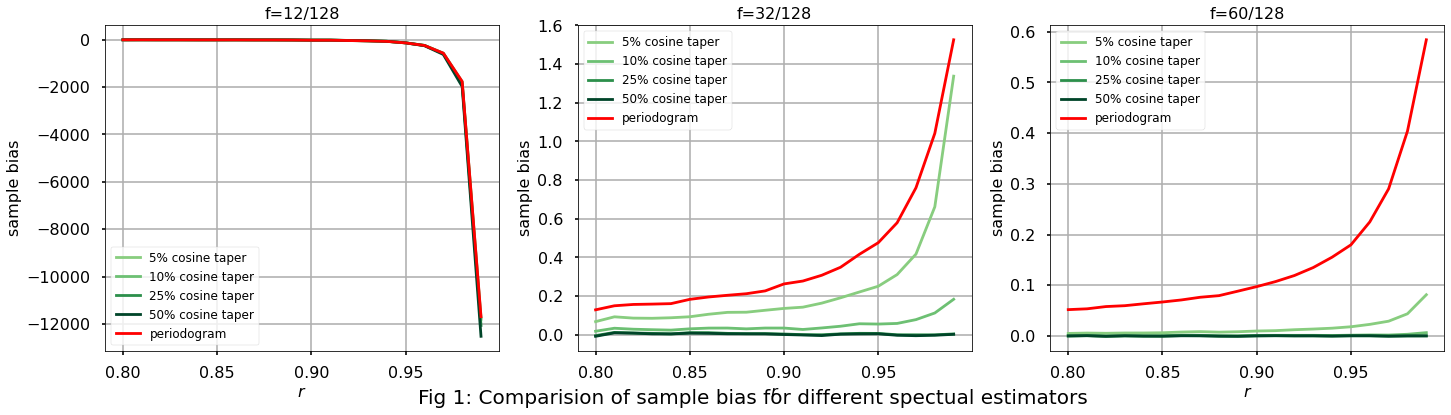

In [10]:
fig = plt.figure(figsize=(24, 6))

for i in range(3):
    plt.subplot(1, 3, i+1)
    for ip in range(4):
        plt.plot(rs, sample_bias[ip+1, :, i], c=cm.YlGn(1.25*ps[ip]+0.4), label=f'{int(ps[ip]*100)}% cosine taper')
    plt.plot(rs, sample_bias[0, :, i], 'r-', label='periodogram')
    plt.xlabel(r'$r$', fontsize=16)
    plt.ylabel('sample bias', fontsize=16)
    plt.title(f'f={int(fs[i]*128)}/128', fontsize=16)
    plt.grid()
    plt.legend(fontsize=12)
# fig.suptitle('Comparision of sample bias for different spectual estimators', fontsize=20)
txt = '\n\nFig 1: Comparision of sample bias for different spectual estimators'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
plt.show()

*(e)*
\begin{itemize}
    \item  As shown in Figure 1, at the oscillating frequency $f=12/128$, spectual density is underestimated by all five estimators, while at the two frequencies away from the oscillating frequency, spectual density is overestimated. This suggests the existence of sidelobe leakage. 
    \item From the two Figure 2 and 4 below, one can see that for larger $r$ the process has larger dynamic range. As a result, for each estimator there are more sidelobe leakage as $r$ gets close to 1, resulting in significantly larger (absolute) sample bias, as shown in Figure 1. 
    \item At the oscillating frequency $f=12/128$, the periodogram and the tapered estimators have similar sample bias. 
    \item At the two frequencies away from the oscillating frequency, the tapered estimators have smaller bias than periodogram. In particular, more tapering (larger $p$) results in larger bias reduction. 
    \item At $f=32/128$, the $25\%$ and $50\%$ taperered estimators have almost zero bias. At $f=60/128$ (even further away from the oscillating frequency), all four cosine tapered estimates have very low bias for $r$ that is not extremely close to 1. 
\end{itemize}

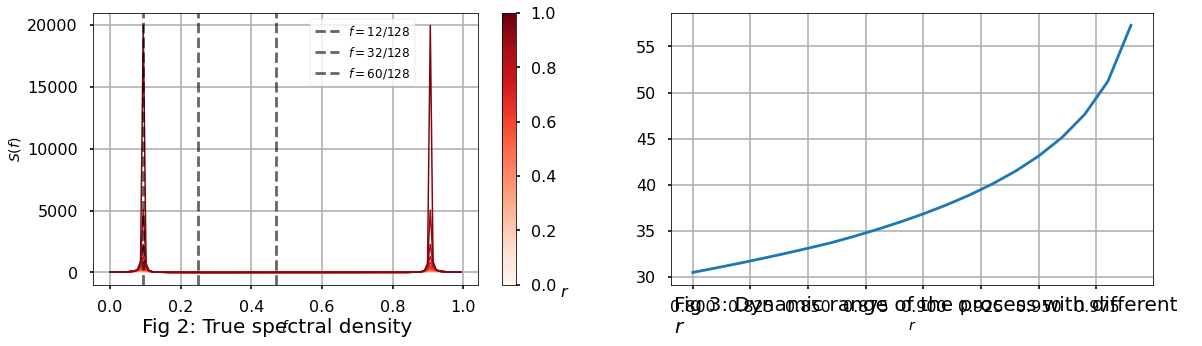

In [11]:
## True sdf
fss = np.arange(128) / 128
sdf = np.array([S_ARMA(fss, sigma2=1, phis=phi, thetas=thetas) for phi in phis])

plt.figure(figsize=(19, 5))
plt.subplot(121)
for k in range(20):
    plt.plot(fss, sdf[k], c=cm.Reds(k/20), lw=1.5)
sm = plt.cm.ScalarMappable(cmap=cm.Reds)

for f in fs:
    plt.axvline(x=f, alpha=0.6, c='k', linestyle='--', label=r'$f=$'+f'{int(f*128)}/128')
cbar = plt.colorbar(sm)
cbar.set_label(r'$r$', rotation=0, fontsize=16, loc='bottom')

plt.xlabel(r'$f$', fontsize=14)
plt.ylabel(r'$S(f)$', fontsize=14)
plt.figtext(0.26, 0.001, '\nFig 2: True spectral density', wrap=True, horizontalalignment='center', fontsize=20)
# plt.title('True spectral density', fontsize=16)
plt.legend(loc=9, bbox_to_anchor=(0.7, 1), fontsize=12)
plt.grid()


## Dynamic range
plt.subplot(122)
dynamic_range = 10 * np.log10(sdf.max(-1) / sdf.min(-1))
plt.plot(rs, dynamic_range)
# plt.title(r'Dynamic range of the process with different $r$', fontsize=14)
plt.figtext(0.55, 0.001, '\nFig 3: Dynamic range of the process with different $r$', wrap=True, fontsize=20)
plt.xlabel(r'$r$', fontsize=14)
plt.grid()
plt.show()


### 2

**(a)**

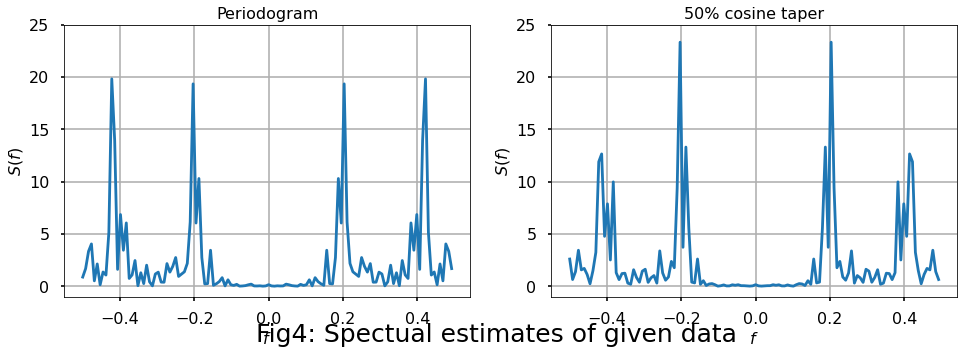

In [12]:
# Load data
X2 = np.genfromtxt('154.csv', delimiter=',')
N = X2.shape[-1]

# Compute periodogram and 50% cosine tapered estimate shifted to (-1/2, 1/2]
per = np.fft.fftshift(periodogram(X2)) 
dse = np.fft.fftshift(direct(X2, 0.5))
titles = ['Periodogram', '50% cosine taper']

# Plot the estimates
fig = plt.figure(figsize=(16, 5))
for i, est in enumerate([per, dse]):
    plt.subplot(1, 2, i+1)
    plt.plot(np.arange(-1/2, 1/2, 1/128), est)
    plt.xlabel(r'$f$', fontsize=16)
    plt.ylabel(r'$S(f)$', fontsize=16)
    plt.title(titles[i], fontsize=16)
    plt.ylim(-1, 25)
    plt.grid()
txt = '\nFig4: Spectual estimates of given data'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=25)
plt.show()


**(b)**
Using the notations as page 65-66 in notes, for **Yule-Walker method (untapered)**, I will construct the arrays and then solve for $$\hat{\mathbb{\phi}}_p=\hat{\Gamma}_p^{-1}\hat{\mathbb{\gamma}}_p, $$
where $\hat{\Gamma}_p^{-1}$ is the symmetric Toeplitz matrix with ($\hat{s}_0,...,\hat{s}_{p-1}$) as its first row, $\hat{\mathbb{\gamma}}_p=(\hat{s}_1,...,\hat{s}_{p})^T$, and $\{\hat{s}_{\tau}\}$ denotes the sample autocovariance sequence of the data $\{X_t\}$.

For **Yule-Walker method with 50% cosine taper**, compute the autocovariance sequence of the tapered series $\{h_tX_t\}$, let this be $\{\hat{s}_{\tau}\}$, then proceed the same as untapered Yule-Walker. 

For **approximate maximum likelihood**, using the same notations as section 5.2 and 5.3 in notes, I will solve for 
$$\hat{\mathbb{\phi}}=(F^TF)^{-1}F^T\mathbf{X},\qquad \sigma^2_{\epsilon}=\frac{(\mathbf{X}-F\hat{\mathbb{\phi}})^T(\mathbf{X}-F\hat{\mathbb{\phi}})}{N-p}$$
where $\mathbf{X}=(X_{p+1}, ..., X_N)^T$, $F$ is the Toeplitz matrix with $(X_p, X_{p-1}, ..., X_1)$ as its first row and $(X_p, X_{p+1}, .., X_{N-1})^T$ as its first column. 

In [13]:
def autocov_seq_hat(X, symmetry=False):
    """Compute the sample autocovariance for a time series."""
    N = X.shape[-1]
    taus = np.arange(-N, N) if symmetry else np.arange(N+1)
    Ts = np.abs(taus).astype(int)
    return np.array([(X[:N-T]*X[T:]).sum() / N for T in Ts])


### Yule-Walker (untapered)
def estimators_YW(X, p):
    """
    Fit an AR(p) model to a given times series using Yule-Walker.

    returns phip_hat: numpy array of length p, containing the phi estimates
    returns sigma2_hat: scalar, estimated variance of the white noise process
    """
    stau_hat = autocov_seq_hat(X)
    Ghat = toeplitz(stau_hat[:p])
    gamma_hat = stau_hat[1:p+1]
    phip_hat = np.linalg.inv(Ghat).dot(gamma_hat)
    sigma2_hat = stau_hat[0] - phip_hat.dot(stau_hat[1:p+1])
    return phip_hat, sigma2_hat


### Yule-Walker with 50% cosine taper
def estimators_YW_tapered(X, p, taper=0.5):
    """
    Fit an AR(p) model to a given times series using Yule-Walker with \
    p*100% cosine taper.
    """
    hX = tapered_series(X, taper)
    N = hX.shape[-1]
    stau_hat = autocov_seq_hat(hX) * N
    Ghat = toeplitz(stau_hat[:p])
    gamma_hat = stau_hat[1:p+1]
    phip_hat = np.linalg.inv(Ghat).dot(gamma_hat)
    sigma2_hat = stau_hat[0] - phip_hat.dot(stau_hat[1:p+1])
    return phip_hat, sigma2_hat


### Approximate MLE
def estimators_MLE(X, p):
    """
    Fit an AR(p) model to a given times series using approximate \
    maximum likelihood.
    """
    N = X.shape[-1]
    F = toeplitz(X[p-1:N-1], X[p-1::-1])
    XX = X[p:]
    phat = np.linalg.inv(F.T @ F) @ F.T @ XX
    A = XX - F.dot(phat)
    sigma2_hat = A.T @ A / (N-p)
    return phat, sigma2_hat

**(c)**

In [14]:
def reduced_AIC(X, p, method='YW'):
    """Compute the AIC score for the three methods above."""
    fmap = {
        'YW': estimators_YW,
        'YW taper': estimators_YW_tapered,
        'MLE': estimators_MLE,
    }
    N = X.shape[-1]
    s2 = fmap[method](X, p)[-1]
    return 2*p + N * np.log(s2)

methods = ['YW', 'YW taper', 'MLE']
YW_data = np.array([reduced_AIC(X2, pp) for pp in range(1, 21)])
YW_taper_data = np.array([reduced_AIC(X2, pp, 'YW taper') for pp in range(1, 21)])
MLE_data = np.array([reduced_AIC(X2, pp, 'MLE') for pp in range(1, 21)])

df = pd.DataFrame(
    {'YW':YW_data, 'YW taper':YW_taper_data, 'MLE':MLE_data}, 
).rename_axis('p').rename(lambda x: x+1, axis='index')
print('AIC scores:')
df

AIC scores:


,YW,YW taper,MLE
p,,,
1,94.783802,101.207951,95.700781
2,88.539991,91.802297,90.444720
3,58.736744,57.057308,59.008583
4,1.434667,-13.417359,-2.080725
5,3.402804,-11.420202,-1.019231
6,3.883213,-10.309071,-0.916525
7,5.722645,-8.343541,0.483330
8,7.525434,-7.086085,3.029029
9,7.697199,-5.566404,1.567323


**(d)**

In [15]:
def best_p(ps, AICs):
    return ps[np.argmin(AICs, -1)]

ps = np.arange(1, 21)
best_ps = best_p(ps, [YW_data, YW_taper_data, MLE_data])
for i in range(3):
    print(f'Best choice of p based on {methods[i]} method = {best_ps[i]}')

YW_coeffs = estimators_YW(X2, best_ps[0])
YW_taper_coeffs = estimators_YW_tapered(X2, best_ps[1])
MLE_coeffs = estimators_MLE(X2, best_ps[2])

print('-------- Estimated parameter values based on the best p --------')
print(f'Yule-Walker: Phi = {YW_coeffs[0]}, sigma^2 = {YW_coeffs[1]}')
print(f'Yule-Walker with 50% taper: Phi = {YW_taper_coeffs[0]}, sigma^2 = {YW_taper_coeffs[1]}')
print(f'Approximate MLE: Phi = {MLE_coeffs[0]}, sigma^2 = {MLE_coeffs[1]}')


Best choice of p based on YW method = 4
Best choice of p based on YW taper method = 4
Best choice of p based on MLE method = 4
-------- Estimated parameter values based on the best p --------
Yule-Walker: Phi = [-0.81623113 -0.71385968 -0.79215113 -0.60892904], sigma^2 = 0.9500015475954233
Yule-Walker with 50% taper: Phi = [-0.82177909 -0.7716625  -0.82390842 -0.65751518], sigma^2 = 0.8459262307072268
Approximate MLE: Phi = [-0.83730632 -0.72914215 -0.81022676 -0.63924543], sigma^2 = 0.9242657257687535


**(e)**

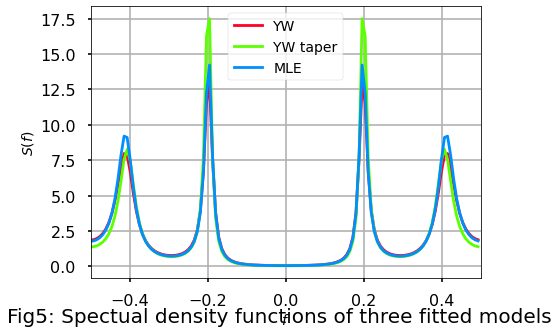

In [16]:
plt.figure(figsize=(7, 5))
for i, data in enumerate([YW_coeffs, YW_taper_coeffs, MLE_coeffs]):
    plt.plot(
        np.arange(-1/2, 1/2, 1/128), 
        S_ARMA(f=np.arange(-1/2, 1/2, 1/128), sigma2=data[1], phis=data[0]), label=methods[i], 
        c=cm.gist_rainbow(i/3)
    )
plt.xlabel(r'$f$',  fontsize=14)
plt.ylabel(r'$S(f)$',fontsize=14)
plt.legend(fontsize=14)
plt.xlim(-1/2, 1/2)
txt = '\nFig5: Spectual density functions of three fitted models'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
plt.grid()
plt.show()

### 3
**(a)**
The forecasting problem is to solve for $X_t(1), ..., X_t(10)$ using the $\text{AR}(p)$ model selected by approximate maximum likelihood method based on $X_1,...,X_{118}$.

Using results on page 92 in the notes, we may forecast the values by seting the future innovation terms to zero, then solving the equations:
$$X_t(1)=\phi_{1, p}X_t+\phi_{2, p}X_{t-1}+\dots+\phi_{p, p}X_{t-p+1}$$
$$X_t(2)=\phi_{1, p}X_t(1)+\phi_{2, p}X_t+\dots+\phi_{p, p}X_{t-p+2}$$
$$\vdots$$
$$X_t(10)=\phi_{1, p}X_t(9)+\phi_{2, p}X_t(8)+\dots+\phi_{p, p}X_{t-p+10}$$

In [17]:
T = 118
tX = X2[:T]
AICs = np.array([reduced_AIC(tX, pp, 'MLE') for pp in range(1, 21)])
p = best_p(range(1, 21), AICs)
phis, sigma2 = estimators_MLE(tX, p)
print(f'Best p value based on first {T} data points = {p}')

# In each iteration, append the newest predicted value to the end of \
# the truncated series, the iteratively using the most present p data \
# points in the series.
for t in range(N-T):
    np.append(tX, phis.dot(tX[-1:-(p+1):-1]))

df = pd.DataFrame(
    {'Predicted data': tX[-(N-T):], 'True data': X2[-(N-T):]}
).rename(lambda x: 'X_'+str(x+1+T), axis='index')
df

Best p value based on first 118 data points = 4


,Predicted data,True data
X_119,2.20780,0.44689
X_120,-0.52338,-1.16920
X_121,-1.86930,0.80533
X_122,-1.58830,-0.52534
X_123,1.12930,0.11856
X_124,1.37470,-1.28770
X_125,-0.10985,3.54240
X_126,-1.29020,-1.16590
X_127,1.33350,-0.82991
X_128,-0.82480,0.27411


**(b)**

In [18]:
ls = N-T
m = 999
eps = np.random.normal(scale=np.sqrt(sigma2), size=(m, ls))

np.random.seed(60046)
Xsims = np.zeros((m, N))
Xsims[:, :T] = np.tile(tX, (m, 1))
for t in range(ls):
    Xsims[:, T+t] = Xsims[:, -1:-(p+1):-1].dot(phis) + eps[:, t]

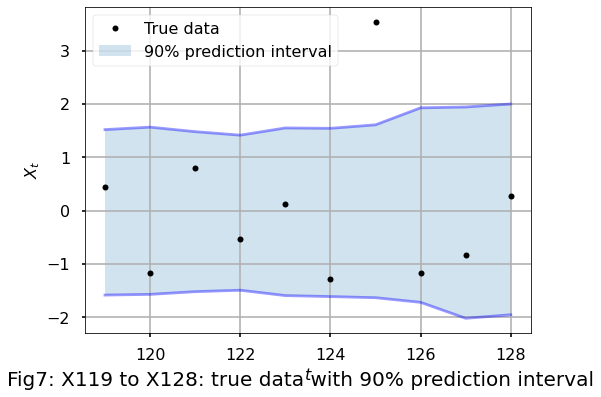

In [19]:
pred_interval = np.sort(Xsims[:, -10:], axis=0)[[49, 949]]
indices = np.arange(T+1, N+1)

plt.figure(figsize=(8, 6))
plt.plot(indices, X2[-ls:], 'ko', markersize=6, label='True data')
plt.plot(indices, pred_interval.T, 'b-', alpha=0.4)
plt.fill_between(indices, pred_interval[0], pred_interval[1], alpha=0.2, label='90% prediction interval')
plt.ylabel(r'$X_t$', fontsize=16)
plt.xlabel(r'$t$', fontsize=16)
txt = '\nFig7: X119 to X128: true data with 90% prediction interval'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
plt.grid()
plt.legend(loc='upper left', fontsize=16)
plt.show()